# Create a Slice with P4 tofino switch running a simple P4 program

In this notebook, we will create a network slice using a P4 Tofino switch and run a simple P4 program. We will connect two nodes through the P4 switch on the same network, enabling them to ping each other.

## Prerequisites
1. Access to a P4 Tofino switch.

2. Two nodes to connect through the switch.

3. Basic understanding of P4 programming.

4. Tofino Software Development Environment (SDE) installed.

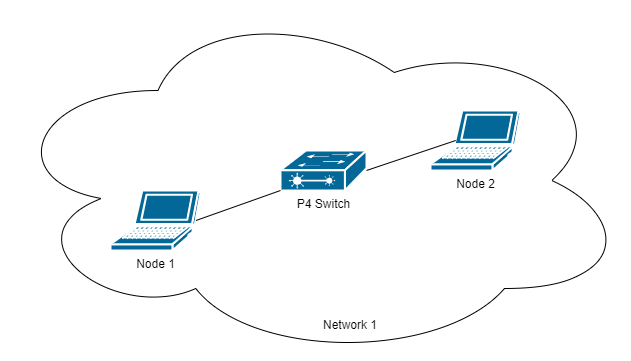

In [5]:
from IPython.display import Image

# Display the image
Image(filename='figs/Simple_P4_Lab.drawio.png')

## Import the FABlib Library


In [6]:
from ipaddress import ip_address, IPv4Address, IPv6Address, IPv4Network, IPv6Network
import ipaddress

from fabrictestbed_extensions.fablib.fablib import FablibManager as fablib_manager

fablib = fablib_manager()

fablib.show_config();

Credential Manager,beta-2.fabric-testbed.net
Orchestrator,beta-7.fabric-testbed.net
Bastion Host,bastion-1.fabric-testbed.net
Core API,beta-3.fabric-testbed.net
Project ID,27244686-8302-4c74-b808-598be32a7839
Bastion Username,vramdhony_0000153089
Bastion Private Key File,/home/fabric/work/fabric_config/bastion2
Slice Private Key File,/home/fabric/work/fabric_config/slice_key
Slice Public Key File,/home/fabric/work/fabric_config/slice_key.pub
Log Level,INFO
Log File,/tmp/fablib/fablib.log


## Create the Experiment Slice

The following script sets up two nodes, each with Shared NICs connected to two ports on a P4 tofino switch.

NIC component model options include:
- NIC_Basic: 100 Gbps Mellanox ConnectX-6 SR-IOV VF (1 Port)
- NIC_ConnectX_5: 25 Gbps Dedicated Mellanox ConnectX-5 PCI Device (2 Ports)
- NIC_ConnectX_6: 100 Gbps Dedicated Mellanox ConnectX-6 PCI Device (2 Ports)

In [3]:
slice_name = 'P4-Lab-Slice'
p4_column_name = "p4-switch_available"

site1 = "LBNL"
site2 = "LBNL"
site3 = "RENC"

node1_name = 'Node1'
node2_name = 'Node2'
p4_name = 'P4'
network1_name = 'Network1'
network2_name = 'Network2'

print(f"Sites: {site1}, {site2}")
print(f"P4 Site: {site3}")

Sites: LBNL, LBNL
P4 Site: RENC


In [4]:
#Create Slice
slice = fablib.new_slice(name=slice_name)

# Create Network
Network1 = slice.add_l2network(name=network1_name, subnet=IPv4Network("192.168.0.0/24"))
Network2 = slice.add_l2network(name=network2_name, subnet=IPv4Network("192.168.0.0/24"))

# Create Node 1 and its links
node1 = slice.add_node(name=node1_name, site=site1)
iface1 = node1.add_component(model='NIC_ConnectX_6', name='nic1').get_interfaces()[0]
iface1.set_mode('config')
Network1.add_interface(iface1)
iface1.set_ip_addr(IPv4Address("192.168.0.1"))

# Create P4 switch and its links 
p4 = slice.add_switch(name=p4_name, site=site3)
iface2 = p4.get_interfaces()[0]
Network1.add_interface(iface2)

iface3 = p4.get_interfaces()[1]
Network2.add_interface(iface3)

# Create Node 2 and its links
node2 = slice.add_node(name=node2_name, site=site2)
iface4 = node2.add_component(model='NIC_ConnectX_6', name='nic1').get_interfaces()[0]
iface4.set_mode('config')
Network2.add_interface(iface4)
iface4.set_ip_addr(IPv4Address("192.168.0.2"))

# Submit Slice Request
slice.submit()


Retry: 8, Time: 664 sec


ID,1a4fd9be-33a3-4446-8dea-9c9acca82979
Name,P4-Lab-Slice
Lease Expiration (UTC),2024-08-03 21:10:14 +0000
Lease Start (UTC),2024-08-02 21:10:14 +0000
Project ID,27244686-8302-4c74-b808-598be32a7839
State,StableOK


ID,Name,Cores,RAM,Disk,Image,Image Type,Host,Site,Username,Management IP,State,Error,SSH Command,Public SSH Key File,Private SSH Key File
7407f7e1-d46f-4d77-b092-289559ed2059,Node1,2,8,10,default_rocky_8,qcow2,lbnl-w2.fabric-testbed.net,LBNL,rocky,2001:400:a100:30d0:f816:3eff:fe38:71c1,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config rocky@2001:400:a100:30d0:f816:3eff:fe38:71c1,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
85bd3c8e-76cc-44ce-a8c0-0a1967e0b568,Node2,2,8,10,default_rocky_8,qcow2,lbnl-w2.fabric-testbed.net,LBNL,rocky,2001:400:a100:30d0:f816:3eff:fe30:4841,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config rocky@2001:400:a100:30d0:f816:3eff:fe30:4841,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
33091485-90a3-4239-aa8f-84fda9f7b455,P4,0,0,0,None,None,None,RENC,None,192.168.11.8,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config None@192.168.11.8,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key


ID,Name,Layer,Type,Site,Subnet,Gateway,State,Error
3a920055-7123-4087-acd3-47322a5746cd,Network1,L2,L2STS,None,192.168.0.0/24,None,Active,
1f4e9cba-0355-46fa-bbbb-d59c6290ed0f,Network2,L2,L2STS,None,192.168.0.0/24,None,Active,


Name,Short Name,Node,Network,Bandwidth,Mode,VLAN,MAC,Physical Device,Device,IP Address,Numa Node,Switch Port
Node1-nic1-p1,p1,Node1,Network1,100,config,,04:3F:72:B7:18:AC,eth1,eth1,192.168.0.1,6,HundredGigE0/0/0/15
Node1-nic1-p2,p2,Node1,None,100,config,,04:3F:72:B7:18:AD,eth2,eth2,fe80::1aea:1930:27d:4deb,6,None
Node2-nic1-p1,p1,Node2,Network2,100,config,,04:3F:72:B7:15:8C,eth1,eth1,192.168.0.2,4,HundredGigE0/0/0/19
Node2-nic1-p2,p2,Node2,None,100,config,,04:3F:72:B7:15:8D,eth2,eth2,fe80::5cc8:5174:8ece:8809,4,None



Time to print interfaces 672 seconds


'1a4fd9be-33a3-4446-8dea-9c9acca82979'

## Run the Experiment

### Configure the P4 Switch. Login locally on P4 switch and perform below commands.

- Go to Lab1 and source config environment
```
cd ~/P4_labs/lab1/
source config_env.sh
```
- Compile the code
```
~/tools/p4_build.sh --with-p4c=bf-p4c p4src/basic.p4
```
- Run the code
```
cd ~/bf-sde-9.13.3
./run_switchd.sh -p basic
```
- Enable Ports on bfshell
```
bf-shell> ucli
bf-sde> pm port-add 1/- 100G NONE
bf-sde> pm port-add 2/- 100G NONE
bf-sde> pm show
-----+----+---+----+-------+----+--+--+---+---+---+--------+----------------+----------------+-
PORT |MAC |D_P|P/PT|SPEED  |FEC |AN|KR|RDY|ADM|OPR|LPBK    |FRAMES RX       |FRAMES TX       |E
-----+----+---+----+-------+----+--+--+---+---+---+--------+----------------+----------------+-
1/0  |23/0|128|2/ 0|100G   | RS |Au|Au|YES|DIS|DWN|  NONE  |               0|               0|
2/0  |22/0|136|2/ 8|100G   | RS |Au|Au|YES|DIS|DWN|  NONE  |               0|               0|
bf-sde> pm port-enb 1/-
bf-sde> pm port-enb 2/-
bf-sde> pm show
-----+----+---+----+-------+----+--+--+---+---+---+--------+----------------+----------------+-
PORT |MAC |D_P|P/PT|SPEED  |FEC |AN|KR|RDY|ADM|OPR|LPBK    |FRAMES RX       |FRAMES TX       |E
-----+----+---+----+-------+----+--+--+---+---+---+--------+----------------+----------------+-
1/0  |23/0|128|2/ 0|100G   | RS |Au|Au|YES|ENB|DWN|  NONE  |               0|               0|
2/0  |22/0|136|2/ 8|100G   | RS |Au|Au|YES|ENB|DWN|  NONE  |               0|               0|
bf-sde>
```

- Set up the forwarding rules on another window:
  - Update the port numbers used in `~/P4_labs/lab1/bfrt_python/setup.py` are same as indicated by D_P column above 
  - Run the commands below
```
cd ~/bf-sde-9.13.3; . ~/tools/set_sde.bash
$SDE/./run_bfshell.sh --no-status-srv -b ~/P4_labs/lab1/bfrt_python/setup.py
```

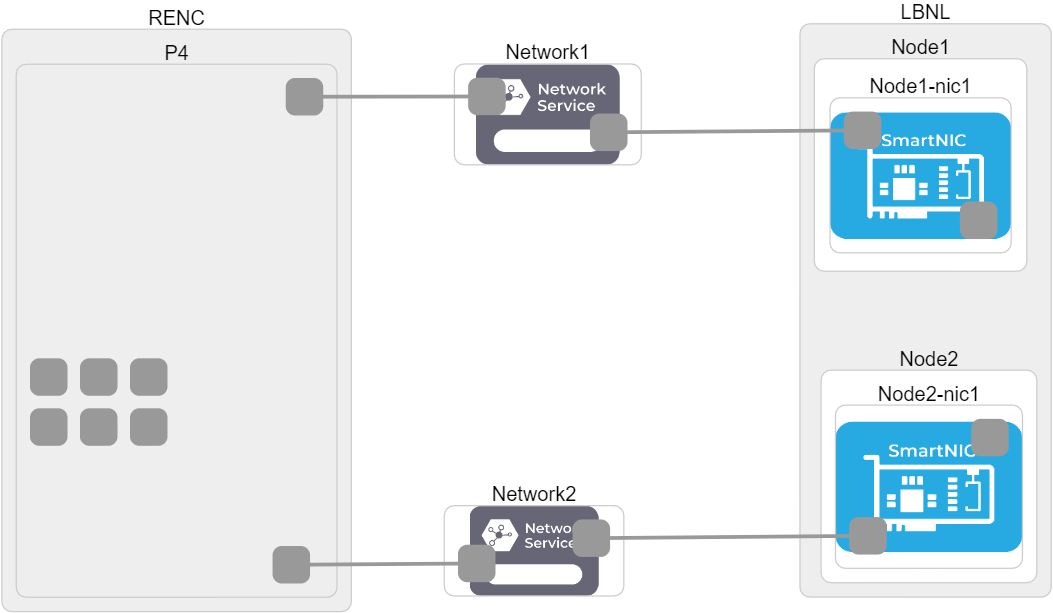

In [5]:
from IPython.display import Image

# Display the image
Image(filename='figs/P4-Lab-Slice.png')

### Verifying Reachability through Ping Tests

In [8]:
slice=fablib.get_slice(slice_name)
node1=slice.get_node(node1_name)
node2=slice.get_node(node2_name)

node1_addr = node1.get_interface(network_name=network1_name).get_ip_addr()
node2_addr = node2.get_interface(network_name=network2_name).get_ip_addr()

stdout, stderr = node1.execute(f'ping -c 5 {node2_addr}')
stdout, stderr = node2.execute(f'ping -c 5 {node1_addr}')

PING 192.168.0.2 (192.168.0.2) 56(84) bytes of data.
64 bytes from 192.168.0.2: icmp_seq=1 ttl=64 time=139 ms
64 bytes from 192.168.0.2: icmp_seq=2 ttl=64 time=139 ms
64 bytes from 192.168.0.2: icmp_seq=3 ttl=64 time=139 ms
64 bytes from 192.168.0.2: icmp_seq=4 ttl=64 time=139 ms
64 bytes from 192.168.0.2: icmp_seq=5 ttl=64 time=139 ms

--- 192.168.0.2 ping statistics ---
5 packets transmitted, 5 received, 0% packet loss, time 4004ms
rtt min/avg/max/mdev = 139.038/139.041/139.046/0.003 ms
PING 192.168.0.1 (192.168.0.1) 56(84) bytes of data.
64 bytes from 192.168.0.1: icmp_seq=1 ttl=64 time=139 ms
64 bytes from 192.168.0.1: icmp_seq=2 ttl=64 time=139 ms
64 bytes from 192.168.0.1: icmp_seq=3 ttl=64 time=139 ms
64 bytes from 192.168.0.1: icmp_seq=4 ttl=64 time=139 ms
64 bytes from 192.168.0.1: icmp_seq=5 ttl=64 time=139 ms

--- 192.168.0.1 ping statistics ---
5 packets transmitted, 5 received, 0% packet loss, time 3999ms
rtt min/avg/max/mdev = 139.034/139.043/139.054/0.471 ms


## Delete the Slice

Please delete your slice when you are done with your experiment.

In [ ]:
slice=fablib.get_slice(slice_name)
slice.delete()